# End-to-end DSPy Workflows Guide 

Time to complete: 1 hour

## Building an Efficient LLM Pipeline with DSPy and Anyscale

## Why DSPy and Anyscale?
DSPy simplifies the complex workflow of:
- Data Collection/Labeling
- Fine-tuning
- Prompt Optimization
- Evaluation

The solution leverages DSPy on Anyscale to distill knowledge from a 70B model into a more cost-effective 1B model, making it practical for production deployment.

- DSPy simplifies complex LLM workflows, from data labeling to deployment
- Anyscale offers scalable infrastructure for training and serving/deploying models

## Scenario: Cost-Effective Customer Support Query Classification

For a bank with limited labeled data (100 examples) and 4,000 unlabeled customer queries:

- DSPy enables easy creation of a pipeline for knowledge distillation from a 70B model to a 1B model in a low data environment
- Anyscale's infrastructure supports efficient fine-tuning and deployment
- Result: A cost-effective, accurate classification system for 25 categories

## Table of Contents

1. Setup
2. Data Processing and Labeling
3. Model Fine-tuning
4. Evaluation and Optimization
5. Production Deployment
6. Future Improvements

## Set up

We will be running everything on A100-80GB GPUs. This is not necessary, especially for running a 1B model. You can edit the serving configuration files used throughout the notebook to use different GPUs if you do not have access to A100s.

We use Anyscale's Auto-select worker node feature to launch and manage child nodes that are running our LLM. You can also set your own compute configuration to autoscale different types of GPUs at different ranges.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import importlib.util

if importlib.util.find_spec("dspy") is None:
    print("Installing dspy")
    # !pip install dspy-ai==2.5.14
    !pip install git+https://github.com/stanfordnlp/dspy.git@anyscale-ft-updates

else:
    print("dspy is already installed")

!pip install matplotlib python-dotenv

dspy is already installed


In order to run this notebook, you need to have the following environment variables set:
- HF_HOME=/mnt/local_storage/huggingface
- HF_TOKEN
- (optional) WANDB_API_KEY

You can get a HF_TOKEN [here](https://huggingface.co/settings/tokens). You will need to request access to the Meta-Llama-3.1-70B-Instruct model and the Llama-3.2-1B-Instruct model.

You can get a WANDB_API_KEY [here](https://wandb.ai/authorize).

In your workspace dashboard, click the "dependencies" tab and add the environment variables, as shown in the image below:

![env_vars](README_files/env_vars.png)

Note that you can separate the variables with a new line to add multiple at once.

In [3]:
import dspy
dspy.settings.configure(experimental=True)

import ujson

from src import set_dspy_cache_location
set_dspy_cache_location("/home/ray/default/dspy/cache")

<b style="background-color: yellow;">&nbsp;🔄 REPLACE&nbsp;</b>: It is a good idea to set the HF_TOKEN, HF_HOME, and WANDB_API_KEY environment variables in the notebook as well.

In [4]:
import os

os.environ["HF_HOME"] = "/mnt/local_storage/huggingface"
# os.environ["HF_TOKEN"] = "hf_12345"
# os.environ["WANDB_API_KEY"] = "12345"

# You can also use a .env file to store your HF_TOKEN and WANDB_API_KEY
# from dotenv import load_dotenv
# load_dotenv()

True

In [5]:
from src import check_env_vars
check_env_vars()

In [6]:
from src import init_ray

init_ray()

2024-10-21 19:38:20,435	INFO worker.py:1601 -- Connecting to existing Ray cluster at address: 10.0.0.36:6379...
2024-10-21 19:38:20,442	INFO worker.py:1777 -- Connected to Ray cluster. View the dashboard at https://session-fkvdirx4bzefi53sjl55m7asad.i.anyscaleuserdata.com 
2024-10-21 19:38:20,463	INFO packaging.py:531 -- Creating a file package for local directory '/home/ray/default/dspy-ai/dspy'.
2024-10-21 19:38:20,489	INFO packaging.py:359 -- Pushing file package 'gcs://_ray_pkg_fa9b5beeb325224f.zip' (0.95MiB) to Ray cluster...
2024-10-21 19:38:20,498	INFO packaging.py:372 -- Successfully pushed file package 'gcs://_ray_pkg_fa9b5beeb325224f.zip'.
2024-10-21 19:38:20,510	INFO packaging.py:359 -- Pushing file package 'gcs://_ray_pkg_b49c5b55e08137baaade17ddec5d8e6b631992ce.zip' (2.02MiB) to Ray cluster...
2024-10-21 19:38:20,525	INFO packaging.py:372 -- Successfully pushed file package 'gcs://_ray_pkg_b49c5b55e08137baaade17ddec5d8e6b631992ce.zip'.


(autoscaler +1m51s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +1m51s) [autoscaler] [4xA100-80GB:48CPU-680GB] Upscaling 1 node(s).
(autoscaler +3m31s) [autoscaler] [4xA100-80GB:48CPU-680GB|a2-ultragpu-4g] [us-east5-b] [on-demand] Launched 1 instances.
(autoscaler +21m27s) [autoscaler] Downscaling node g-6e19439aa854e0001 (node IP: 10.0.0.40) due to node idle termination.
(autoscaler +37m1s) [autoscaler] [8CPU-32GB] Upscaling 1 node(s).
(autoscaler +37m16s) [autoscaler] [8CPU-32GB|n2-standard-8] [us-east5-a] [on-demand] Launched 1 instances.
(autoscaler +38m36s) [autoscaler] [4xA100-80GB:48CPU-680GB] Upscaling 1 node(s).
(autoscaler +40m11s) [autoscaler] [4xA100-80GB:48CPU-680GB|a2-ultragpu-4g] [us-east5-b] [on-demand] Launched 1 instances.
(autoscaler +41m23s) [autoscaler] Cluster upscaled to {56 CPU, 4 GPU}.
(autoscaler +46m7s) [autoscaler] [4xA100-80GB:48CPU-680GB] Upscaling 1 node(s).
(autoscaler +47m47s)

We will make use of a random number generator in this notebook. We are creating a Random object here to ensure that our notebook is reproducible.

In [7]:
from src import set_random_seed
rng = set_random_seed()

We will be using the PolyAI/banking77 dataset for this tutorial. We use the built in dspy DataLoader to load the dataset from Huggingface as a list of dspy.Example objects.

In [8]:
%%capture
# Prepare the dataset
from src import load_data_from_huggingface, convert_int_label_to_string
full_trainset, full_testset = load_data_from_huggingface()

full_trainset_processed, full_testset_processed = convert_int_label_to_string(full_trainset, full_testset)

The dataset is originally called "banking77" because there are 77 labels. We will be reducing this to the top 25 most frequent labels.

In [9]:
from src import filter_to_top_n_labels
full_trainset_filtered, full_testset_filtered, top_25_labels = filter_to_top_n_labels(full_trainset_processed, full_testset_processed, n=25)

print(f"Dataset filtered to top 25 labels. New sizes:")
print(f"Training set size: {len(full_trainset_filtered)}; Test set size: {len(full_testset_filtered)}")
print(f"Top 25 labels: {', '.join(str(label) for label in top_25_labels)}")
print(f"Example training set: {full_trainset_filtered[0]}")
print(f"Example test set: {full_testset_filtered[0]}")

Dataset filtered to top 25 labels. New sizes:
Training set size: 4171; Test set size: 1000
Top 25 labels: card_payment_fee_charged, direct_debit_payment_not_recognised, balance_not_updated_after_cheque_or_cash_deposit, wrong_amount_of_cash_received, cash_withdrawal_charge, transaction_charged_twice, declined_cash_withdrawal, transfer_fee_charged, balance_not_updated_after_bank_transfer, transfer_not_received_by_recipient, request_refund, card_payment_not_recognised, card_payment_wrong_exchange_rate, extra_charge_on_statement, wrong_exchange_rate_for_cash_withdrawal, refund_not_showing_up, reverted_card_payment, cash_withdrawal_not_recognised, activate_my_card, pending_card_payment, cancel_transfer, beneficiary_not_allowed, card_arrival, declined_card_payment, pending_top_up
Example training set: Example({'label': 'card_arrival', 'text': 'I am still waiting on my card?'}) (input_keys={'text'})
Example test set: Example({'label': 'card_arrival', 'text': 'How do I locate my card?'}) (inpu

In [10]:
labels_in_use = top_25_labels
print(labels_in_use)

['card_payment_fee_charged', 'direct_debit_payment_not_recognised', 'balance_not_updated_after_cheque_or_cash_deposit', 'wrong_amount_of_cash_received', 'cash_withdrawal_charge', 'transaction_charged_twice', 'declined_cash_withdrawal', 'transfer_fee_charged', 'balance_not_updated_after_bank_transfer', 'transfer_not_received_by_recipient', 'request_refund', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'extra_charge_on_statement', 'wrong_exchange_rate_for_cash_withdrawal', 'refund_not_showing_up', 'reverted_card_payment', 'cash_withdrawal_not_recognised', 'activate_my_card', 'pending_card_payment', 'cancel_transfer', 'beneficiary_not_allowed', 'card_arrival', 'declined_card_payment', 'pending_top_up']


Now we will shuffle our training set and split it into a training and labeled set.

The scenario we are emulating is that we only have 100 labeled examples to train on. We are saying that we have 4K (length of the training set) unlabeled examples we can then label using an oracle model, and then distill the knowledge from the oracle model into our 1B model.

In [11]:
from src import common_kwargs, delete_labels

shuffled_trainset = [d for d in full_trainset_filtered]
rng.shuffle(shuffled_trainset)

# The devset shouldn't overlap
ft_trainset = shuffled_trainset[:-100]
labeled_trainset = shuffled_trainset[-100:]

# For realism of this scenario, we are going to delete all our labels except for our test set(which is cheating and we wouldn't have in production) and our 100 true labeled examples
ft_trainset_to_label = delete_labels(ft_trainset)

testset = full_testset_filtered
evaluate_testset = dspy.Evaluate(devset=testset, **common_kwargs)

# Implementing a Simple Chain of Thought Program in DSPy

## Defining the Signature

At the heart of our DSPy program is the `Signature` class. This class serves as a blueprint, outlining the inputs and outputs of our language model task. Here's how we structure it:

1. **Docstring for Context**: We utilize the docstring to provide context to the LLM. In this case, we're passing our fixed set of 25 labels directly in the docstring. This approach is ideal when dealing with a static set of options.

2. **Input Field**: We define an `intent` field as the input to our program. This will contain the natural language query we want to classify.

3. **Output Field**: The `label` field represents our desired output - the classified intent.

Both input and output fields are accompanied by concise descriptions, just to help the LLM understand the task.

By structuring our program this way, we utilize DSPy's capabilities to create a clear, modular design that's both powerful and easy to maintain. 

In [12]:
class IntentClassification(dspy.Signature):
    """As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
    The intent should exactly match one of the following:
    ['card_payment_fee_charged', 'direct_debit_payment_not_recognised', 'balance_not_updated_after_cheque_or_cash_deposit', 'wrong_amount_of_cash_received', 'cash_withdrawal_charge', 'transaction_charged_twice', 'declined_cash_withdrawal', 'transfer_fee_charged', 'balance_not_updated_after_bank_transfer', 'transfer_not_received_by_recipient', 'request_refund', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'extra_charge_on_statement', 'wrong_exchange_rate_for_cash_withdrawal', 'refund_not_showing_up', 'reverted_card_payment', 'cash_withdrawal_not_recognised', 'activate_my_card', 'pending_card_payment', 'cancel_transfer', 'beneficiary_not_allowed', 'card_arrival', 'declined_card_payment', 'pending_top_up']
    """

    intent = dspy.InputField(desc="Intent of the query")
    label = dspy.OutputField(desc="Type of the intent; Should just be one of the 25 labels with no other text")

For the module, we create a dspy.Module class that contains the Chain of Thought predictor using the signature we defined above.
We also pass in the valid labels to the module.

Inside the forward method, we pass the text to the predictor, do a little cleaning, and return the prediction.

In [13]:
class IntentClassificationModule(dspy.Module):
    def __init__(self, labels_in_use):
        self.intent_classifier = dspy.ChainOfThought(IntentClassification)
        self.valid_labels = set(labels_in_use)

    def forward(self, text):
        prediction = self.intent_classifier(intent=text)
        sanitized_prediction = dspy.Prediction(label=prediction.label.lower().strip().replace(" ", "_"), reasoning=prediction.reasoning)
        return sanitized_prediction

Lastly, we set up some the vanilla program we will use throughout the notebook.

In [14]:
from src import MODEL_PARAMETERS, LOCAL_API_PARAMETERS
vanilla_program = IntentClassificationModule(labels_in_use)

In [15]:
# Note: Run above this to do all setup without launching any models
# This is useful if you have already collected data and want to start from finetuning or from evaluation

Note that by default, the cache directory used by HuggingFace is in the home directory (`/home/ray` here). We'll use `/mnt/local_storage` here for downloading large model weight files (140GB+)

# Deploying and Utilizing a 70B Language Model

This section outlines the process of deploying and utilizing a 70B parameter language model for data gathering and training. Key steps include:

1. Configuration: Use a pre-generated serve config file (created via `rayllm gen-config`) to configure the RayLLM instance.
2. Infrastructure: Leverage Anyscale's RayLLM with Auto-select worker nodes for GPU allocation.

Below we show the contents of the serve config and its corresponding model config file.

In [ ]:
import yaml
from src import get_serve_and_model_config, update_serve_config_hf_token

get_serve_and_model_config("serve_70B.yaml")
update_serve_config_hf_token("serve_70B.yaml")

In [18]:
!serve run --non-blocking serve_70B.yaml

2024-10-21 19:39:47,884	INFO scripts.py:489 -- Running config file: 'serve_70B.yaml'.
2024-10-21 19:39:48,151	INFO worker.py:1601 -- Connecting to existing Ray cluster at address: 10.0.0.36:6379...
2024-10-21 19:39:48,156	INFO worker.py:1777 -- Connected to Ray cluster. View the dashboard at https://session-fkvdirx4bzefi53sjl55m7asad.i.anyscaleuserdata.com 
2024-10-21 19:39:48,162	INFO packaging.py:359 -- Pushing file package 'gcs://_ray_pkg_ab551c637a1658aa9cd63a9a346b70d4a7dcefd2.zip' (2.02MiB) to Ray cluster...
2024-10-21 19:39:48,181	INFO packaging.py:372 -- Successfully pushed file package 'gcs://_ray_pkg_ab551c637a1658aa9cd63a9a346b70d4a7dcefd2.zip'.
INFO 2024-10-21 19:39:58,684 serve 11368 api.py:277 - Started Serve in namespace "serve".
(ProxyActor pid=11594) INFO 2024-10-21 19:39:58,649 proxy 10.0.0.36 proxy.py:1235 - Proxy starting on node c90774698ca9837eefaa2d051c0cbbc38e74b90063934fa44ead0a38 (HTTP port: 8000).
2024-10-21 19:39:58,690	SUCC scripts.py:540 -- Submitted deplo

In [19]:
llama_70b = dspy.LM(model="openai/meta-llama/Meta-Llama-3.1-70B-Instruct", **MODEL_PARAMETERS, **LOCAL_API_PARAMETERS)

You can expect the cell below to take around 8-10 minutes to run, as it waits for the cluster to recruit a worker node if necessary and also downloads the 70B model weights.

In [20]:
from src import sanity_check_program

sanity_check_program(llama_70b, vanilla_program, ft_trainset[0])

Program input: Example({'text': 'I still have not received an answer as to why I was charged $1.00 in a transaction?'}) (input_keys={'text'})


Program output label: extra_charge_on_statement


### Bootstrap Data


In this section, we bootstrap data for fine-tuning.

We delete all the true labels to be accurate to the scenario, and then collect data from the oracle LLM.

We use a metric that checks if the prediction is in the set of labels we are using to get rid of any nonsense labels that the oracle LLM may hallucinate.

In [21]:
from dspy.teleprompt.finetune_teleprompter import bootstrap_data, convert_to_module_level_message_data
from src import delete_labels, NUM_THREADS, write_jsonl
from src.data_preprocess import valid_label_metric

with dspy.context(lm=llama_70b):
    collected_data = bootstrap_data(vanilla_program, ft_trainset_to_label, num_threads=NUM_THREADS, max_errors=10000, metric=valid_label_metric)
    # Make sure to only include the labels we are actively using or that arent hallucinated by the oracle
    collected_data_filtered = [x for x in collected_data if x["prediction"]["label"] in labels_in_use]
    
    dataset = convert_to_module_level_message_data(collected_data_filtered, program=vanilla_program, exclude_demos=True)

    dataset_formatted = [{"messages": item} for item in dataset]

print(dataset_formatted[0])
print("Length of dataset:\t", len(dataset))

Average Metric: 4064 / 4071  (99.8): 100%|██████████| 4071/4071 [16:12<00:00,  4.19it/s]


{'messages': [{'role': 'system', 'content': "Your input fields are:\n1. `intent` (str): Intent of the query\n\nYour output fields are:\n1. `reasoning` (str): ${produce the output fields}. We ...\n2. `label` (str): Type of the intent; Should just be one of the 25 labels with no other text\n\nAll interactions will be structured in the following way, with the appropriate values filled in.\n\n[[ ## intent ## ]]\n{intent}\n\n[[ ## reasoning ## ]]\n{reasoning}\n\n[[ ## label ## ]]\n{label}\n\n[[ ## completed ## ]]\n\nIn adhering to this structure, your objective is: \n        As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.\n        The intent should exactly match one of the following:\n        ['card_payment_fee_charged', 'direct_debit_payment_not_recognised', 'balance_not_updated_after_cheque_or_cash_deposit', 'wrong_amount_of_cash_received', 'cash_withdrawal_charge', 'transaction_charged_twice', 'declined_cash_withdra

# Fine-tuning

We will use LLM Forge to fine-tune the 1B model.

In order to do this, we need to format our data into the correct format (Follows OpenAI messaging format).

Anyscale now has a first class integration with DSPy for finetuning. Anyscale offers a tool for finetuning called LLMForge, which DSPy will interface with to do the actual finetuning using your own cluster on the task you defined above.

We can let DSPy do the rest, where it will properly generate the config and run the finetuning.

Be sure to checkout the fine-tuning documentation for the latest on how to use our [API](https://docs.anyscale.com/llms/finetuning/intro) and additional [capabilities](https://docs.anyscale.com/category/fine-tuning-beta/).

We'll fine-tune our LLM by choosing a set of configurations. We have created recipes for different LLMs in the [`training configs`](configs/training/lora/llama-3-8b.yaml) folder which can be used as is or modified for experiments. These configurations provide flexibility over a broad range of parameters such as model, data paths, compute to use for training, number of training epochs, how often to save checkpoints, padding, loss, etc. We also include several [DeepSpeed](https://github.com/microsoft/DeepSpeed) [configurations](configs/deepspeed/zero_3_offload_optim+param.json) to choose from for further optimizations around data/model parallelism, mixed precision, checkpointing, etc.

We also have recipes for [LoRA](https://arxiv.org/abs/2106.09685) (where we train a set of small low ranked matrices instead of the original attention and feed forward layers) or full parameter fine-tuning. We recommend starting with LoRA as it's less resource intensive and quicker to train.

In [23]:
from dspy.clients.lm import TrainingMethod
from src import load_finetuning_kwargs

train_data = dataset_formatted
method = TrainingMethod.SFT

finetuneable_lm = dspy.LM(model="meta-llama/Llama-3.2-1B-Instruct")

try:
    finetuning_job = finetuneable_lm.finetune(train_data=train_data[:50], train_kwargs=load_finetuning_kwargs(), train_method=method, provider="anyscale")
    final_lm = finetuning_job.result()
except Exception as e:
    print(e)

Copying file:///home/ray/.dspy_cache/finetune/anyscale_7d1f84638a49fc4c.jsonl to gs://storage-bucket-cld-tffbxe9ia5phqr1unxhz4f7e1e/org_4snvy99zwbmh4gbtk64jfqggmj/cld_tffbxe9ia5phqr1unxhz4f7e1e/artifact_storage/anyscale_7d1f84638a49fc4c.jsonl
  

(anyscale +1h10m55.2s) Uploading local dir '.' to cloud storage.
(anyscale +1h10m57.6s) Job 'dspy-llmforge-fine-tuning-job' submitted, ID: 'prodjob_bxek1v285nq6qwm7rqfw9atlth'.
(anyscale +1h10m57.6s) View the job in the UI: https://console.anyscale.com/jobs/prodjob_bxek1v285nq6qwm7rqfw9atlth
(anyscale +1h10m57.8s) Waiting for job 'prodjob_bxek1v285nq6qwm7rqfw9atlth' to reach target state SUCCEEDED, currently in state: STARTING
(anyscale +1h12m50.9s) Job 'prodjob_bxek1v285nq6qwm7rqfw9atlth' transitioned from STARTING to RUNNING
(anyscale +1h20m55.3s) Job 'prodjob_bxek1v285nq6qwm7rqfw9atlth' transitioned from RUNNING to SUCCEEDED
(anyscale +1h20m55.3s) Job 'prodjob_bxek1v285nq6qwm7rqfw9atlth' reached target state, exiting


# Evaluation

## Performance comparisons

**Synthetic Devset:**
- 1B Non-finetuned
- 1B Non-finetuned + Prompt Optimization
- 1B Finetuned (all checkpoints)
- 1B Finetuned (all checkpoints) + Prompt Optimization

**Test set:**
- 1B Non-finetuned + Prompt Optimization
- 1B Finetuned + Prompt Optimization (best on devset)

Note that for this task, where the eval loss of a checkpoint isn't necessarily informative of the downstream performance of the program, because there are chains of though inside output, we need to test all possible checkpoints to see which one performs best.

In [25]:
print(final_lm.model)

meta-llama/Llama-3.2-1B-Instruct:isaac:ekwsj


We will run a local RayLLM instance that serves the model.

Provided with this template is are two files, `serve_1B.yaml` and `\model_configs\meta-llama--Llama-3_2-1B-Instruct.yaml`. 

The first file, `serve_1B.yaml`, contains the serve configuration to load the model with RayLLM.

The second file, `\model_configs\meta-llama--Llama-3_2-1B-Instruct.yaml`, contains the necessary configurations to run the 1B model.

<b style="background-color: yellow;">&nbsp;🔄 REPLACE&nbsp;</b>:
Make sure you set your HF_TOKEN and HF_HOME environment variables in the workspace runtime environment variables, and run the following command to start the server:

In [26]:
from src import update_serve_config_hf_token

update_serve_config_hf_token("serve_1B.yaml")

Lets kill the server if it is already running

In [ ]:
!serve shutdown -y

Run this command to start the 1B RayLLM server:

In [42]:
!serve run --non-blocking serve_1B.yaml

2024-10-21 21:14:00,225	INFO scripts.py:489 -- Running config file: 'serve_1B.yaml'.
2024-10-21 21:14:00,513	INFO worker.py:1601 -- Connecting to existing Ray cluster at address: 10.0.0.36:6379...
2024-10-21 21:14:00,519	INFO worker.py:1777 -- Connected to Ray cluster. View the dashboard at https://session-fkvdirx4bzefi53sjl55m7asad.i.anyscaleuserdata.com 
2024-10-21 21:14:00,524	INFO packaging.py:359 -- Pushing file package 'gcs://_ray_pkg_f59fda81a6ce3fb3211e557710e413084a7446fe.zip' (1.92MiB) to Ray cluster...
2024-10-21 21:14:00,542	INFO packaging.py:372 -- Successfully pushed file package 'gcs://_ray_pkg_f59fda81a6ce3fb3211e557710e413084a7446fe.zip'.
(ProxyActor pid=43890) INFO 2024-10-21 21:14:03,596 proxy 10.0.0.36 proxy.py:1235 - Proxy starting on node c90774698ca9837eefaa2d051c0cbbc38e74b90063934fa44ead0a38 (HTTP port: 8000).
INFO 2024-10-21 21:14:03,618 serve 43719 api.py:277 - Started Serve in namespace "serve".
2024-10-21 21:14:03,624	SUCC scripts.py:540 -- Submitted deploy

In [43]:
from src import MODEL_PARAMETERS, LOCAL_API_PARAMETERS

non_ft_llama = dspy.LM(model="openai/meta-llama/Llama-3.2-1B-Instruct", **MODEL_PARAMETERS, **LOCAL_API_PARAMETERS)

all_llamas = {"base": non_ft_llama, "ft": final_lm}

openai/meta-llama/Llama-3.2-1B-Instruct:isaac:ekwsj


In [44]:
# Sanity check that the finetuned models are working

finetuned_llama = list(all_llamas.values())[1]
sanity_check_program(finetuned_llama, vanilla_program, ft_trainset[0])

Program input: Example({'text': 'I still have not received an answer as to why I was charged $1.00 in a transaction?'}) (input_keys={'text'})


ValueError: Expected dict_keys(['reasoning', 'label']) but got dict_keys([])

We are going to be doing prompt optimization using DSPy's `BootstrapFewShotWithRandomSearch (BFRS)` function.

BFRS will:
- Collect a set of chains of thought from the oracle
- Use these examples that lead to a correct prediction to "bootstrap" the program
- See which set of examples lead to the most correct predictions across your evaluation metric
- Continue this process for a set number of iterations, using the best performing programs to bootstrap the next iteration
- Return the best program

Let's go over what the hyperparameters mean:
- **max_bootstrapped_demos**: DSPy will "bootstrap" the program by collecting examples at each step that are successful and reusing those in the pipeline. This means that it will automatically collect and add chains of thought to the pipeline.
- **max_labeled_demos**: DSPy will also insert some labeled demonstrations from the training set. These would be unmodified examples from the training set that are just using the given answer.
- **num_candidate_programs**: This is the number of candidate programs that the optimizer will generate. The actual number of programs that are created is this plus three, as DSPy will also try a program with no examples, a program with just the labeled demonstrations, and a bootstrapped program with the first few examples.


In [45]:
from src import bootstrap_fewshot_random_search_parameters, metric

print("Parameters:")
for k, v in bootstrap_fewshot_random_search_parameters.items():
    print(f"{k}: {v}")

Parameters:
max_bootstrapped_demos: 3
max_labeled_demos: 3
num_candidate_programs: 6


In [46]:
from src import split_into_devset_and_optimizer_sets

def collected_data_to_example(data):
    return dspy.Example(text=data["example"]["text"], label=data["prediction"]["label"]).with_inputs("text")

collected_data_examples = [collected_data_to_example(x) for x in collected_data_filtered]

devset_synthetic, ft_optimizer_trainset, ft_optimizer_devset = split_into_devset_and_optimizer_sets(collected_data_examples, dev_size=1000, optimizer_num_val=300)
print("Lengths:")
print("Synthetic Devset:\t", len(devset_synthetic))
print("Optimizer Trainset:\t", len(ft_optimizer_trainset))
print("Optimizer Devset:\t", len(ft_optimizer_devset))
print("Example from synthetic devset:")
print(devset_synthetic[0])

Lengths:
Synthetic Devset:	 1000
Optimizer Trainset:	 2762
Optimizer Devset:	 300
Example from synthetic devset:
Example({'text': 'I still have not received an answer as to why I was charged $1.00 in a transaction?', 'label': 'extra_charge_on_statement'}) (input_keys={'text'})


Now we will take all of our checkpoints and the base mode, prompt optimize them, and evaluate them on the synthetic devset.

Note that there is a `%%capture` below. This is to suppress the output of the evaluation and prompt optimization because it is quite long. We will graph the results in the cell after. You can remove it to see the output.

You can expect this to take around 15 minutes to run.

In [48]:
%%capture
from src import evaluate_and_prompt_optimize

evaluation_kwargs = {
    "models": all_llamas,
    "module_class": IntentClassificationModule,
    "optimizer_trainset": ft_optimizer_trainset,
    "optimizer_valset": ft_optimizer_devset,
    "devset": devset_synthetic,
    "metric": metric,
    "labels_in_use": labels_in_use
}

ft_results = evaluate_and_prompt_optimize(**evaluation_kwargs)

Going to sample between 1 and 3 traces per predictor.
Will attempt to bootstrap 6 candidate sets.
Evaluating openai/meta-llama/Llama-3.2-1B-Instruct


2024-10-21T21:44:57.913808Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024-10-21T21:44:57.914833Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024-10-21T21:44:57.915710Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200


2024-10-21T21:44:57.916927Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024-10-21T21:44:57.917864Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024-10-21T21:44:57.919364Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024-10-21T21:44:57.920161Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024

New best score: 0.0 for seed -3
Scores so far: [0.0]
Best score so far: 0.0


2024-10-21T21:45:08.547891Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024-10-21T21:45:08.549028Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024-10-21T21:45:08.550136Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024-10-21T21:45:08.550963Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024

Scores so far: [0.0, 0.0]
Best score so far: 0.0


  0%|          | 0/2762 [00:00<?, ?it/s]2024-10-21T21:45:11.047841Z [error    ] Failed to run or to evaluate example Example({'text': "For some reason my card payment hasn't worked. what can I do to look into that?", 'label': 'card_payment_not_recognised'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x794343ce3af0> due to Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-21T21:45:11.054879Z [error    ] Failed to run or to evaluate example Example({'text': 'What is the proper way to activate a card?', 'label': 'activate_my_card', 'answer': 'activate_my_card'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x794343ce3af0> due to Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-21T21:45:11.061771Z [error    ] Failed to run or to evaluate example Example({'text': 'The ATM is messed up. It 

Bootstrapped 3 full traces after 1357 examples in round 0.


2024-10-21T21:45:20.760859Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
Average Metric: 111.0 / 300  (37.0): 100%|██████████| 300/300 [00:00<00:00, 913.40it/s]


New best score: 37.0 for seed -1
Scores so far: [0.0, 0.0, 37.0]
Best score so far: 37.0


  0%|          | 0/2762 [00:00<?, ?it/s]2024-10-21T21:45:21.237061Z [error    ] Failed to run or to evaluate example Example({'text': 'I did a transfer.  What is the extra fee?', 'label': 'transfer_fee_charged'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x794343ce3af0> due to Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-21T21:45:21.243936Z [error    ] Failed to run or to evaluate example Example({'text': 'Why do I get a fee every time I transfer?', 'label': 'transfer_fee_charged'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x794343ce3af0> due to Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-21T21:45:21.250691Z [error    ] Failed to run or to evaluate example Example({'text': 'I am being charged a pound out of nowhere. What is this?', 'label': 'extra_charge_on_statement'})

Bootstrapped 2 full traces after 1522 examples in round 0.


2024-10-21T21:45:32.223876Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024-10-21T21:45:32.227333Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
Average Metric: 76.0 / 300  (25.3): 100%|██████████| 300/300 [00:00<00:00, 502.77it/s]


Scores so far: [0.0, 0.0, 37.0, 25.33]
Best score so far: 37.0


  0%|          | 0/2762 [00:00<?, ?it/s]2024-10-21T21:45:32.988399Z [error    ] Failed to run or to evaluate example Example({'text': 'My card payment was reverted', 'label': 'reverted_card_payment'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x794343ce3af0> due to Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-21T21:45:32.994880Z [error    ] Failed to run or to evaluate example Example({'text': "I've used my account frequently over the last month to manage my payments from abroad for my new place. I noticed that my fees have suddenly increased. As a frequent customer, shouldn't I be rewarded rather than suddenly being subject to a new fee?", 'label': 'extra_charge_on_statement'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x794343ce3af0> due to Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lin

Bootstrapped 1 full traces after 381 examples in round 0.


2024-10-21T21:45:35.832351Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
Average Metric: 77.0 / 300  (25.7): 100%|██████████| 300/300 [00:00<00:00, 801.93it/s]


Scores so far: [0.0, 0.0, 37.0, 25.33, 25.67]
Best score so far: 37.0


  0%|          | 0/2762 [00:00<?, ?it/s]2024-10-21T21:45:36.351369Z [error    ] Failed to run or to evaluate example Example({'text': 'I got a strange cash withdrawal in my statement', 'label': 'cash_withdrawal_not_recognised'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x794343ce3af0> due to Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-21T21:45:36.359099Z [error    ] Failed to run or to evaluate example Example({'text': 'I topped up and went to buy something, but it says that my funds are pending. Is there a way to quicken this process?', 'label': 'pending_top_up'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x794343ce3af0> due to Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-21T21:45:36.366704Z [error    ] Failed to run or to evaluate example Example({'text': 'top up not 

Bootstrapped 1 full traces after 667 examples in round 0.


2024-10-21T21:45:41.133532Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024-10-21T21:45:41.135282Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024-10-21T21:45:41.136515Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024-10-21T21:45:41.137486Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
Aver

Scores so far: [0.0, 0.0, 37.0, 25.33, 25.67, 15.33]
Best score so far: 37.0


  0%|          | 0/2762 [00:00<?, ?it/s]2024-10-21T21:45:42.539191Z [error    ] Failed to run or to evaluate example Example({'text': 'I tried to withdraw 50 pounds but it only gave me 30. Where is the rest of my money?', 'label': 'wrong_amount_of_cash_received'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x794343ce3af0> due to Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-21T21:45:42.546871Z [error    ] Failed to run or to evaluate example Example({'text': 'Why did my cash deposit not show up?', 'label': 'balance_not_updated_after_cheque_or_cash_deposit'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x794343ce3af0> due to Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-21T21:45:42.554734Z [error    ] Failed to run or to evaluate example Example({'text': 'I just had my card get

Bootstrapped 1 full traces after 1279 examples in round 0.


2024-10-21T21:45:51.907376Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024-10-21T21:45:51.910648Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
Average Metric: 73.0 / 300  (24.3): 100%|██████████| 300/300 [00:00<00:00, 439.08it/s]


Scores so far: [0.0, 0.0, 37.0, 25.33, 25.67, 15.33, 24.33]
Best score so far: 37.0


  0%|          | 0/2762 [00:00<?, ?it/s]2024-10-21T21:45:52.755937Z [error    ] Failed to run or to evaluate example Example({'text': 'I purchased something overseas and the incorrect exchange rate was applied.', 'label': 'card_payment_wrong_exchange_rate'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x794343ce3af0> due to Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-21T21:45:52.762915Z [error    ] Failed to run or to evaluate example Example({'text': "Hi! I'm a university student studying abroad and I noticed that when I was trying to cross-reference my budget for this month that there were extra fees I was not expecting. Why is that? I've had this account for years and I haven't had any trouble so far, it might not even be on your all's end since I'm still new to international travel and finance, but I wanted to double check in case a mistake was made!", 'label': 'extra_charge_

Bootstrapped 1 full traces after 140 examples in round 0.


2024-10-21T21:45:53.725612Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024-10-21T21:45:53.728127Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
Average Metric: 73.0 / 300  (24.3): 100%|██████████| 300/300 [00:00<00:00, 437.12it/s]


Scores so far: [0.0, 0.0, 37.0, 25.33, 25.67, 15.33, 24.33, 24.33]
Best score so far: 37.0


  0%|          | 0/2762 [00:00<?, ?it/s]2024-10-21T21:45:54.580528Z [error    ] Failed to run or to evaluate example Example({'text': "Why isn't my cash deposit showing up in my account? I deposited it this morning.", 'label': 'balance_not_updated_after_cheque_or_cash_deposit'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x794343ce3af0> due to Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-21T21:45:54.587403Z [error    ] Failed to run or to evaluate example Example({'text': 'I  have been charged more than I should for the presents I bought  when abroad, the problem seems to be the exchange rate.', 'label': 'card_payment_wrong_exchange_rate'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x794343ce3af0> due to Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-21T21:45:54.594508Z [err

Bootstrapped 3 full traces after 2322 examples in round 0.


2024-10-21T21:46:11.280582Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
Average Metric: 104.0 / 300  (34.7): 100%|██████████| 300/300 [00:00<00:00, 832.79it/s]


Scores so far: [0.0, 0.0, 37.0, 25.33, 25.67, 15.33, 24.33, 24.33, 34.67]
Best score so far: 37.0
9 candidate programs found.


2024-10-21T21:46:11.797560Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024-10-21T21:46:11.800606Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024-10-21T21:46:11.811122Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024-10-21T21:46:11.825953Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024

Evaluation result for base on devset: 34.6
Going to sample between 1 and 3 traces per predictor.
Will attempt to bootstrap 6 candidate sets.
Evaluating openai/meta-llama/Llama-3.2-1B-Instruct:isaac:ekwsj


2024-10-21T21:46:12.630001Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024-10-21T21:46:12.631181Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024-10-21T21:46:12.631750Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024-10-21T21:46:12.632431Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024

New best score: 0.33 for seed -3
Scores so far: [0.33]
Best score so far: 0.33


2024-10-21T21:46:23.377700Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024-10-21T21:46:23.378812Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024-10-21T21:46:23.380280Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024-10-21T21:46:23.381008Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024

Scores so far: [0.33, 0.33]
Best score so far: 0.33


  0%|          | 0/2762 [00:00<?, ?it/s]2024-10-21T21:46:25.835453Z [error    ] Failed to run or to evaluate example Example({'text': "For some reason my card payment hasn't worked. what can I do to look into that?", 'label': 'card_payment_not_recognised'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x794343ce3af0> due to Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-21T21:46:25.842785Z [error    ] Failed to run or to evaluate example Example({'text': 'The ATM is messed up. It gave me less than I wanted.', 'label': 'wrong_amount_of_cash_received'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x794343ce3af0> due to Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-21T21:46:25.849458Z [error    ] Failed to run or to evaluate example Example({'text': "I attempted to top up my account

Bootstrapped 3 full traces after 72 examples in round 0.


2024-10-21T21:46:26.320483Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024-10-21T21:46:26.323999Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
Average Metric: 100.0 / 300  (33.3): 100%|██████████| 300/300 [00:00<00:00, 851.02it/s]


New best score: 33.33 for seed -1
Scores so far: [0.33, 0.33, 33.33]
Best score so far: 33.33


  0%|          | 0/2762 [00:00<?, ?it/s]2024-10-21T21:46:26.830973Z [error    ] Failed to run or to evaluate example Example({'text': 'I did a transfer.  What is the extra fee?', 'label': 'transfer_fee_charged'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x794343ce3af0> due to Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-21T21:46:26.837691Z [error    ] Failed to run or to evaluate example Example({'text': 'Why do I get a fee every time I transfer?', 'label': 'transfer_fee_charged'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x794343ce3af0> due to Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-21T21:46:26.844343Z [error    ] Failed to run or to evaluate example Example({'text': 'I am being charged a pound out of nowhere. What is this?', 'label': 'extra_charge_on_statement'})

Bootstrapped 2 full traces after 1522 examples in round 0.


2024-10-21T21:46:42.108730Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
Average Metric: 95.0 / 300  (31.7): 100%|██████████| 300/300 [00:07<00:00, 40.16it/s]


Scores so far: [0.33, 0.33, 33.33, 31.67]
Best score so far: 33.33


  0%|          | 2/2762 [00:00<13:25,  3.43it/s]2024-10-21T21:46:51.254411Z [error    ] Failed to run or to evaluate example Example({'text': "on my statement there is a payment that I don't recognise", 'label': 'card_payment_not_recognised'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x794343ce3af0> due to Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-21T21:46:51.514045Z [error    ] Failed to run or to evaluate example Example({'text': 'How long will it take for my money to be deposited?', 'label': 'balance_not_updated_after_bank_transfer'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x794343ce3af0> due to Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
  0%|          | 4/2762 [00:00<08:52,  5.18it/s]2024-10-21T21:46:51.523685Z [error    ] Failed to run or to evaluate example Example

Bootstrapped 1 full traces after 853 examples in round 0.


2024-10-21T21:49:12.128985Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
Average Metric: 47.0 / 300  (15.7): 100%|██████████| 300/300 [00:08<00:00, 36.70it/s]


Scores so far: [0.33, 0.33, 33.33, 31.67, 15.67]
Best score so far: 33.33


  0%|          | 0/2762 [00:00<?, ?it/s]2024-10-21T21:49:21.005423Z [error    ] Failed to run or to evaluate example Example({'text': 'I got a strange cash withdrawal in my statement', 'label': 'cash_withdrawal_not_recognised'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x794343ce3af0> due to Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-21T21:49:21.255033Z [error    ] Failed to run or to evaluate example Example({'text': 'I topped up and went to buy something, but it says that my funds are pending. Is there a way to quicken this process?', 'label': 'pending_top_up'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x794343ce3af0> due to Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
  0%|          | 2/2762 [00:00<05:54,  7.78it/s]2024-10-21T21:49:21.263121Z [error    ] Failed to run or t

Bootstrapped 1 full traces after 667 examples in round 0.


2024-10-21T21:50:21.285317Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024-10-21T21:50:21.287794Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024-10-21T21:50:21.288998Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024-10-21T21:50:21.289466Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
Aver

Scores so far: [0.33, 0.33, 33.33, 31.67, 15.67, 15.67]
Best score so far: 33.33


  0%|          | 0/2762 [00:00<?, ?it/s]2024-10-21T21:50:22.686725Z [error    ] Failed to run or to evaluate example Example({'text': 'I tried to withdraw 50 pounds but it only gave me 30. Where is the rest of my money?', 'label': 'wrong_amount_of_cash_received'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x794343ce3af0> due to Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-21T21:50:22.694051Z [error    ] Failed to run or to evaluate example Example({'text': 'Why did my cash deposit not show up?', 'label': 'balance_not_updated_after_cheque_or_cash_deposit'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x794343ce3af0> due to Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-21T21:50:22.700929Z [error    ] Failed to run or to evaluate example Example({'text': 'I just had my card get

Bootstrapped 1 full traces after 764 examples in round 0.


2024-10-21T21:51:22.608188Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024-10-21T21:51:22.677964Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024-10-21T21:51:22.759674Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024-10-21T21:51:22.893472Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
Aver

Scores so far: [0.33, 0.33, 33.33, 31.67, 15.67, 15.67, 17.0]
Best score so far: 33.33


  0%|          | 0/2762 [00:00<?, ?it/s]2024-10-21T21:51:29.297260Z [error    ] Failed to run or to evaluate example Example({'text': 'I purchased something overseas and the incorrect exchange rate was applied.', 'label': 'card_payment_wrong_exchange_rate'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x794343ce3af0> due to Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-21T21:51:29.306371Z [error    ] Failed to run or to evaluate example Example({'text': "Hi! I'm a university student studying abroad and I noticed that when I was trying to cross-reference my budget for this month that there were extra fees I was not expecting. Why is that? I've had this account for years and I haven't had any trouble so far, it might not even be on your all's end since I'm still new to international travel and finance, but I wanted to double check in case a mistake was made!", 'label': 'extra_charge_

Bootstrapped 1 full traces after 1070 examples in round 0.


2024-10-21T21:52:24.858172Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
Average Metric: 51.0 / 300  (17.0): 100%|██████████| 300/300 [00:07<00:00, 38.75it/s]


Scores so far: [0.33, 0.33, 33.33, 31.67, 15.67, 15.67, 17.0, 17.0]
Best score so far: 33.33


  0%|          | 0/2762 [00:00<?, ?it/s]2024-10-21T21:52:33.069636Z [error    ] Failed to run or to evaluate example Example({'text': "Why isn't my cash deposit showing up in my account? I deposited it this morning.", 'label': 'balance_not_updated_after_cheque_or_cash_deposit'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x794343ce3af0> due to Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-21T21:52:33.257252Z [error    ] Failed to run or to evaluate example Example({'text': 'I  have been charged more than I should for the presents I bought  when abroad, the problem seems to be the exchange rate.', 'label': 'card_payment_wrong_exchange_rate'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x794343ce3af0> due to Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
  0%|          | 2/2762 [00:00<0

Bootstrapped 3 full traces after 759 examples in round 0.


2024-10-21T21:53:04.949953Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
Average Metric: 87.0 / 300  (29.0): 100%|██████████| 300/300 [00:07<00:00, 40.83it/s]


Scores so far: [0.33, 0.33, 33.33, 31.67, 15.67, 15.67, 17.0, 17.0, 29.0]
Best score so far: 33.33
9 candidate programs found.


2024-10-21T21:53:15.569330Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024-10-21T21:53:15.681215Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024-10-21T21:53:15.779984Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024-10-21T21:53:15.965969Z [error    ] Error for example in dev set: 		 Expected dict_keys(['reasoning', 'label']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=200
2024

Evaluation result for ft on devset: 28.7


In [32]:
if True:
    import json
    with open("ft_results.json", "w") as f:
        json.dump(ft_results, f)
else:
    ft_results = json.load(open("ft_results.json"))

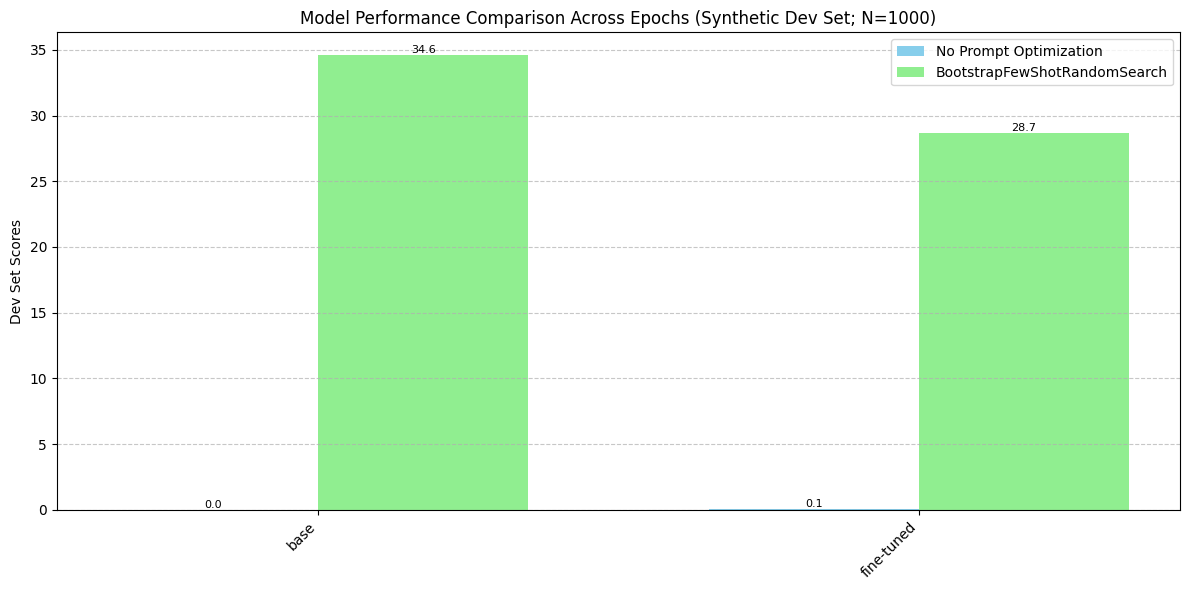

Highest Dev Set Score: 34.6, Model: base


In [49]:
from src import graph_devset_results, graph_testset_results

graph_devset_results(ft_results)

We see that the highest performing model is the final epoch with a score of 50.2 on our synthetic devset.

We will now take this best performing model and evaluate it and our prompt optimized base model on the true test set to see if we have improved performance.

This should take around 10 minutes to run.

In [34]:
%%capture
# Now we need to evaluate the test set
from src import run_testset_evaluation

testset_evaluation_kwargs = {
    "ft_results": ft_results,
    "all_llamas": all_llamas,
    "labels_in_use": labels_in_use,
    "testset": testset,
    "metric": metric,
    "module_class": IntentClassificationModule
}

ft_results_testset, (best_program_path, best_model, best_score) = run_testset_evaluation(**testset_evaluation_kwargs)

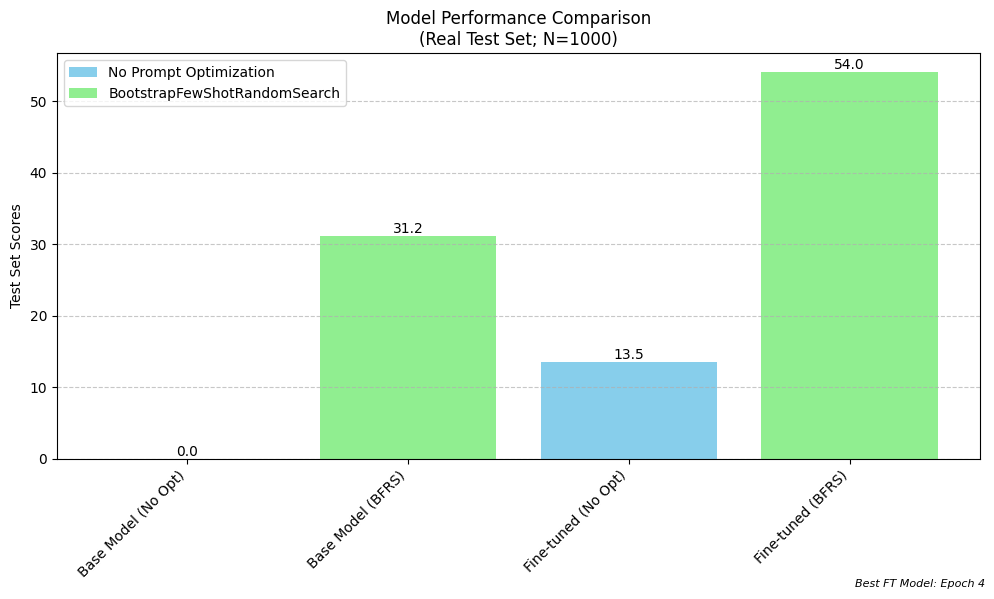

In [35]:
graph_testset_results(ft_results_testset)

In [36]:
print(f"Best testset result: \n{best_model} with score: {best_score}")

Best testset result: 
meta-llama/Llama-3.2-1B-Instruct:epochs-4-total-trained-steps-160 with score: 54.0


# Serving

# TODO: Add context about what we are doing

<b style="background-color: blue;">&nbsp;🔄 RUN (optional)&nbsp;</b>:
You can optionally deploy your model to Anyscale in order to use it in production.
To do this, run the following command:

```
!anyscale service deploy -f serve_1B.yaml
```

Follow the URL in order to find your service URL and API key for your deployed service.

If you choose not to deploy your model, you can run the following code to run the model locally.
```
serve run serve_1B.yaml
```

If you never took down your service from the previous section, there is no need to rerun the service run command.

In [ ]:
# !anyscale service deploy -f serve_1B.yaml
# !serve run serve_1B.yaml

<b style="background-color: yellow;">&nbsp;🔄 REPLACE&nbsp;</b>:
Replace the following variables with your Anyscale service URL and API key.

```
ANYSCALE_SERVICE_BASE_URL = None
ANYSCALE_API_KEY = None
```

You can find them by clicking the query button on the Anyscale dashboard for your service.

<!-- <img src="files/service-query.png" alt="Service Query" width="500"> -->
![Service Query](README_files/service-query.png)

In [37]:
ANYSCALE_SERVICE_BASE_URL = None
ANYSCALE_API_KEY = None

In [38]:
from src import MODEL_PARAMETERS, LOCAL_API_PARAMETERS
if ANYSCALE_SERVICE_BASE_URL and ANYSCALE_API_KEY:
    API_PARAMETERS = {"api_base": ANYSCALE_SERVICE_BASE_URL, "api_key": ANYSCALE_API_KEY}
else:
    API_PARAMETERS = LOCAL_API_PARAMETERS

Now we can use ray serve in order to deploy our DSPy program.

The RayLLM instance you deployed will autoscale according to the number of requests you make based on the configuration inside of the `serve_1B.yaml` file.

Ray serve does all the hard work for you there, so all you need to do is provide the URL and API key to query your model.

Now to deploy the DSPy program on top of the RayLLM instance, we can create a FastAPI wrapper around our DSPy program.

In [89]:
from ray import serve
from fastapi import FastAPI

app = FastAPI()

@serve.deployment(
    ray_actor_options={"num_cpus": 0.1},
    autoscaling_config=dict(min_replicas=1, max_replicas=3)
)
@serve.ingress(app)
class LLMClient:
    def __init__(self):
        self.llm = dspy.LM(model="openai/" + best_model, **MODEL_PARAMETERS, **API_PARAMETERS)
        dspy.settings.configure(experimental=True, lm=self.llm)
        self.program = IntentClassificationModule(labels_in_use)
        self.program.load(best_program_path)

    @app.get("/")
    async def classify_intent(
        self,
        query: str,
    ):
        """Answer the given question and provide sources."""
        retrieval_response = self.program(query)

        return retrieval_response.label

llm_client = LLMClient.bind()
llm_handle = serve.run(llm_client, route_prefix="/classify_intent", name="llm_client")

INFO 2024-10-19 01:34:51,639 serve 14470 api.py:259 - Connecting to existing Serve app in namespace "serve". New http options will not be applied.
WARNING 2024-10-19 01:34:51,641 serve 14470 api.py:85 - The new client HTTP config differs from the existing one in the following fields: ['host']. The new HTTP config is ignored.


INFO 2024-10-19 01:34:57,689 serve 14470 client.py:492 - Deployment 'LLMClient:xrueus8l' is ready at `http://0.0.0.0:8000/classify_intent`. component=serve deployment=LLMClient
INFO 2024-10-19 01:34:57,692 serve 14470 api.py:549 - Deployed app 'llm_client' successfully.


In [82]:
example_query = ft_trainset[1]["text"]
llm_response = await llm_handle.classify_intent.remote(
    query=example_query,
)
print(example_query)
print(llm_response)

My card was charged more than expected.
card_payment_fee_charged


We can also query directly using HTTP requests, because we use the `@app` decorator on our FastAPI app.

In [91]:
import requests
try:
    response = requests.get(f"http://localhost:8000/classify_intent?query={example_query}")
    print(response.json())
except Exception as e:
    print(e)

card_payment_fee_charged


<b style="background-color: yellow;">&nbsp;🛑 IMPORTANT&nbsp;</b>: Please `Terminate` your service from the Service page to avoid depleting your free trial credits.

In [ ]:
# Clean up
!python src/clear_cell_nums.py
!find . | grep -E ".ipynb_checkpoints" | xargs rm -rf
!find . | grep -E "(__pycache__|\.pyc|\.pyo)" | xargs rm -rf
!rm -rf __pycache__ data .HF_TOKEN deploy/services